In [1]:
sub_list = ['005','006','007']
task_list = ['localizer','imagine']
mask_list=['bilateral_hippo','bilateral_oc-temp']

In [2]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import nibabel as nib
import nilearn
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn import plotting
from nilearn.plotting import plot_roi
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import scipy.io
#from mpi4py import MPI
import os
import pickle 
import time
from scipy.sparse import random
from scipy.stats import zscore
from scipy.spatial.distance import euclidean
from pathlib import Path
from shutil import copyfile
import seaborn as sns
import importlib
import csv

# Import machine learning libraries
import sklearn
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, PredefinedSplit
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

%matplotlib inline 
%autosave 5

Autosaving every 5 seconds


In [3]:
from platform import python_version
print('The python version is {}.'.format(python_version()))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The numpy version is {}.'.format(np.__version__))
print('The nilearn version is {}.'.format(nilearn.__version__))
print('The seaborn version is {}.'.format(sns.__version__))

The python version is 3.9.10.
The scikit-learn version is 1.0.2.
The numpy version is 1.20.3.
The nilearn version is 0.8.1.
The seaborn version is 0.11.2.


In [4]:
# Set printing precision
np.set_printoptions(precision=2, suppress=True)

# load some helper functions
sys.path.insert(0, '/jukebox/norman/karina/adderzip_fMRI/adderzip/code/mainanalysis')

#localizer
import adderzip_utils
from adderzip_utils import load_adderzip_stim_labels_localizer,load_adderzip_epi_data, shift_timing, label2TR, mask_data

importlib.reload(adderzip_utils)

# load some constants
from adderzip_utils import adderzip_dir, adderzip_bids_dir, adderzip_label_dict, n_runs, run_names, adderzip_TR, adderzip_hrf_lag, TRs_run

anat_dir=adderzip_bids_dir + 'derivatives/deface/'
out_dir= adderzip_bids_dir + 'derivatives/firstlevel/'
fmriprep_dir=adderzip_bids_dir + 'derivatives/fmriprep/'
data_dir='/jukebox/norman/karina/adderzip_fMRI/adderzip/data/mainanalysis/output'

task = task_list[0]
print('TASKS:', task)
print('LIST OF ALL TASKS:', run_names)
task_index = run_names.index(task)
print('task index:', task_index)
print('')

n_runs_localizer = n_runs[task_index]

TRs_run_localizer=90

print('ROIs = %s' % (mask_list))
print('Labels = %s' % (adderzip_label_dict))
print('number of runs = %d' % (n_runs_localizer))
print('TRs per run after trimming = %s' % (TRs_run_localizer))

TASKS: localizer
LIST OF ALL TASKS: ['localizer']
task index: 0

ROIs = ['bilateral_hippo', 'bilateral_oc-temp']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects', 0: 'Rest'}
number of runs = 3
TRs per run after trimming = 90


In [5]:
#imagine
import adderzip_utils_imagine
from adderzip_utils_imagine import load_adderzip_stim_labels_imagine,load_adderzip_epi_data, shift_timing, label2TR, mask_data

# load some constants
from adderzip_utils_imagine import adderzip_dir, adderzip_bids_dir, adderzip_label_dict_imagine, adderzip_TR, adderzip_hrf_lag, run_names, run_order_start, n_runs, TRs_run

importlib.reload(adderzip_utils_imagine)

task = task_list[1]
print('TASK:', task)
print('LIST OF TASKS:', run_names)
task_index = run_names.index(task)
print('task index:', task_index)
print('')

n_runs_imagine = n_runs[task_index]

TRs_run_imagine=TRs_run[0]-5-10
TRs_run_extra_imagine=TRs_run[3]-5-10

trials_run_imagine = 32
trials_run_extra_imagine = 48

print('ROIs = %s' % (mask_list))
print('Labels = %s' % (adderzip_label_dict_imagine))
print('number of runs = %d' % (n_runs_imagine))
print('TRs per run after trimming = %s' % (TRs_run_imagine))
print('TRs per run after trimming = %s' % (TRs_run_extra_imagine))

TASK: imagine
LIST OF TASKS: ['imagine']
task index: 0

ROIs = ['bilateral_hippo', 'bilateral_oc-temp']
Labels = {0: 'Scenes', 1: 'Faces'}
number of runs = 2
TRs per run after trimming = 144
TRs per run after trimming = 216


In [6]:
def classifier(bold_train, labels_train, bold_test, labels_test, model,linReg):
    # normalize the data 
    scaler = StandardScaler()
    bold_train = scaler.fit_transform(bold_train)
    bold_test = scaler.fit_transform(bold_test)


    # Fit the model
    model.fit(bold_train, labels_train)

    # Compute your evaluation on the test set
    score = model.score(bold_test, labels_test)
    print('Accuracy = %s' % score)
    
    if linReg == 1:
        prediction = model.predict(bold_test)
        prediction_prob = model.predict_proba(bold_test)
    else:
        prediction = 'NA'
        prediction_prob = 'NA'
    
    return score, prediction, prediction_prob

model_linearSVC = LinearSVC(C=1)
model_linReg_1 = LogisticRegression(C=1.0, random_state=34, solver='liblinear')

In [7]:
def calc_auc(y_true,y_scores): 
    fpr,tpr,threshold = roc_curve(y_true,y_scores,pos_label=1)

    roc_auc = auc(fpr,tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #title=' %s classifier for all 3 runs for %s subjects' % (classiType,partiNum)
    #plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

In [8]:
#005, train on localizer test on imagine
def getLabel(this_sub,this_task): 
    
    label_dir = data_dir + '/label_list_%s/labels_%s.csv' % (this_task, this_sub)
    thisLabel = open(label_dir)
    thisLabel = csv.reader(thisLabel)
    thisLabel = list(thisLabel)
    thisLabel = np.array(thisLabel)
    thisLabel = np.float64(thisLabel)
    
    return thisLabel

def getBold(this_sub,this_task,this_mask):
    
    bold_dir = data_dir + '/bold_data_%s/%s/bold_%s.csv' % (this_task, this_mask, this_sub)
    thisBold = open(bold_dir)
    thisBold = csv.reader(thisBold)
    thisBold = list(thisBold)
    thisBold = np.array(thisBold)
    thisBold = np.float64(thisBold)
    
    return thisBold

In [9]:
def binarize(labels, category):
    
    find_zeros = np.where(labels[:] == 0)[0] #to double check that numbers line up
    find_ones = np.where(labels[:] == 1)[0] #to double check that numbers line up
    find_twos = np.where(labels[:] == 2)[0] #to double check that numbers line up
    find_threes = np.where(labels[:] == 3)[0] #to double check that numbers line up
    
    if category == 'faces':
        labels[find_ones] = 1
        labels[find_twos] = 0
        labels[find_threes] = 0
    if category == 'scenes':
        labels[find_ones] = 0
        labels[find_twos] = 1
        labels[find_threes] = 0
    if category == 'scenes':
        labels[find_ones] = 0
        labels[find_twos] = 0
        labels[find_threes] = 1
        
    return labels

005
(270, 6428)
(270, 1)
(360, 6428)
(360, 1)
Accuracy = 0.5805555555555556


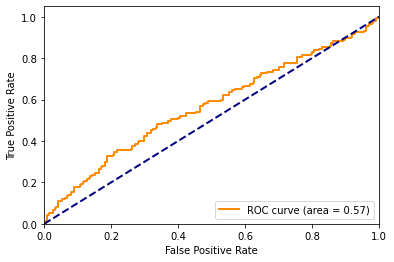

mean roc auc 0.5662551440329219
006
(270, 7477)
(270, 1)
(360, 7477)
(360, 1)
Accuracy = 0.5055555555555555


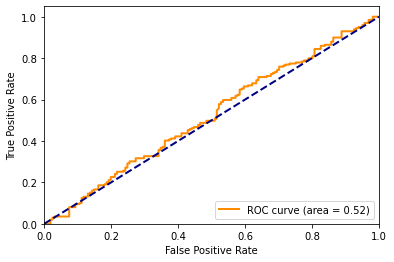

mean roc auc 0.5437318355702547
007
(270, 7187)
(270, 1)
(360, 7187)
(360, 1)
Accuracy = 0.5416666666666666


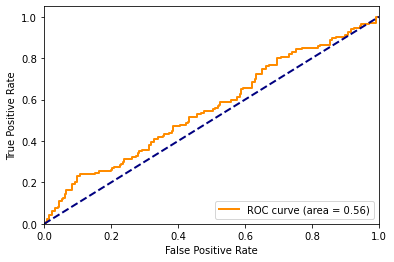

mean roc auc 0.5484826951175449


In [11]:
for eachSubj in range(len(sub_list)):
    subNum = sub_list[eachSubj]
    print(subNum)
    
    trainBold = getBold(subNum,'localizer','bilateral_oc-temp')
    trainLabel = getLabel(subNum,'localizer')
    #print(trainLabel[:5])
    #print(trainLabel[-5:])
    trainLabel = binarize(trainLabel,'faces')
    #print(trainLabel[:5])
    #print(trainLabel[-5:])
    print(trainBold.shape)
    print(trainLabel.shape)

    testBold = getBold(subNum,'imagine','bilateral_oc-temp')
    testLabel = getLabel(subNum,'imagine')
    #testLabel = testLabel.astype(int)
    #print(testLabel[:5])
    #print(testLabel[-5:])
    print(testBold.shape)
    print(testLabel.shape)

    score, prediction, prediction_prob = classifier(trainBold,trainLabel,testBold,testLabel,model_linReg_1,1)
    #print(prediction_prob[:5,:])

    y_true = np.ravel(testLabel)
    y_true = list(y_true)
    #print(y_true)

    y_score = prediction_prob[:,1]
    #print(y_score)

    roc_auc = calc_auc(y_true,y_score)
    
    if eachSubj == 0:
        roc_auc_sum = roc_auc
    else:
        roc_auc_sum = roc_auc_sum + roc_auc
        
    mean_roc_auc = roc_auc_sum/(eachSubj+1)
    print('mean roc auc', mean_roc_auc)

005
trainBold (144, 1950)
trainLabel (144, 1)
testBold (144, 1950)
testLabel (144, 1)
Accuracy = 0.4791666666666667


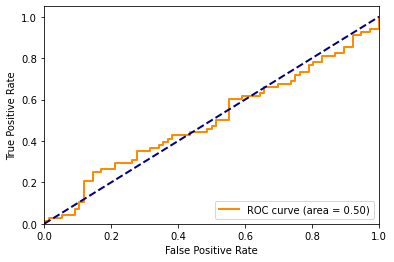

mean roc auc 0.49941950464396284
006
trainBold (144, 2503)
trainLabel (144, 1)
testBold (144, 2503)
testLabel (144, 1)
Accuracy = 0.5416666666666666


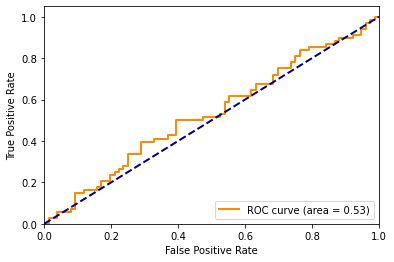

mean roc auc 0.5148026315789473
007
trainBold (144, 2476)
trainLabel (144, 1)
testBold (144, 2476)
testLabel (144, 1)
Accuracy = 0.5347222222222222


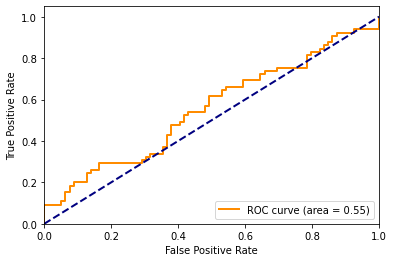

mean roc auc 0.5274276550675617


In [24]:
for eachSubj in range(len(sub_list)):
    subNum = sub_list[eachSubj]
    print(subNum)
    
    imagineBold = getBold(subNum,'imagine','bilateral_hippo')
    imagineLabel = getLabel(subNum,'imagine')
    #print(trainLabel[:5])
    #print(trainLabel[-5:])
    
    trainBold = imagineBold[:144,:]
    testBold = imagineBold[144:288,:]
    trainLabel = imagineLabel[:144]
    testLabel = imagineLabel[144:288]
    
    print('trainBold',trainBold.shape)
    print('trainLabel',trainLabel.shape)
    print('testBold',testBold.shape)
    print('testLabel',testLabel.shape)
    
    score, prediction, prediction_prob = classifier(trainBold,trainLabel,testBold,testLabel,model_linReg_1,1)
    #print(prediction_prob[:5,:])

    y_true = np.ravel(testLabel)
    y_true = list(y_true)
    #print(y_true)

    y_score = prediction_prob[:,1]
    #print(y_score)

    roc_auc = calc_auc(y_true,y_score)
    
    if eachSubj == 0:
        roc_auc_sum = roc_auc
    else:
        roc_auc_sum = roc_auc_sum + roc_auc
        
    mean_roc_auc = roc_auc_sum/(eachSubj+1)
    print('mean roc auc', mean_roc_auc)




In [17]:
def split(bold_data,labels,trials_run_localizer):
    
    run1_bold = bold_data[0:trials_run_localizer,:]
    run1_labels = labels[0:trials_run_localizer]

    run2_bold = bold_data[trials_run_localizer:(trials_run_localizer*2),:]
    run2_labels = labels[trials_run_localizer:(trials_run_localizer*2)]

    run3_bold = bold_data[(trials_run_localizer*2):(trials_run_localizer*3),:]
    run3_labels = labels[(trials_run_localizer*2):(trials_run_localizer*3)]

    fold1_bold_train = np.vstack((run2_bold,run3_bold))
    fold1_labels_train = np.vstack((run2_labels,run3_labels))

    fold1_bold_test = run1_bold
    fold1_labels_test = run1_labels

    fold2_bold_train = np.vstack((run1_bold,run3_bold))
    fold2_labels_train = np.vstack((run1_labels,run3_labels))

    fold2_bold_test = run2_bold
    fold2_labels_test = run2_labels

    fold3_bold_train = np.vstack((run1_bold,run2_bold))
    fold3_labels_train = np.vstack((run1_labels,run2_labels))

    fold3_bold_test = run3_bold
    fold3_labels_test = run3_labels
    
    return fold1_bold_train,fold2_bold_train,fold3_bold_train,fold1_labels_train,fold2_labels_train,fold3_labels_train,fold1_bold_test,fold2_bold_test,fold3_bold_test,fold1_labels_test,fold2_labels_test,fold3_labels_test

def get_bold_and_labels(fold,fold1_bold_train,fold2_bold_train,fold3_bold_train,fold1_labels_train,fold2_labels_train,fold3_labels_train,fold1_bold_test,fold2_bold_test,fold3_bold_test,fold1_labels_test,fold2_labels_test,fold3_labels_test):
    
    if fold ==1:
        return fold1_bold_train, fold1_labels_train, fold1_bold_test, fold1_labels_test
    if fold ==2:
        return fold2_bold_train, fold2_labels_train, fold2_bold_test, fold2_labels_test
    if fold ==3:
        return fold3_bold_train, fold3_labels_train, fold3_bold_test, fold3_labels_test

005
trainBold (180, 6428)
trainLabel (180, 1)
testBold (90, 6428)
testLabel (90, 1)
Accuracy = 0.3111111111111111


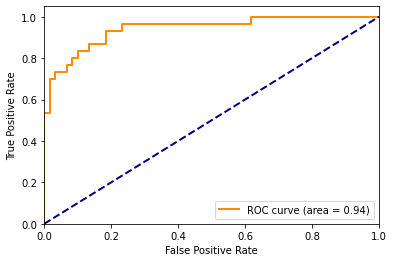

trainBold (180, 6428)
trainLabel (180, 1)
testBold (90, 6428)
testLabel (90, 1)
Accuracy = 0.28888888888888886


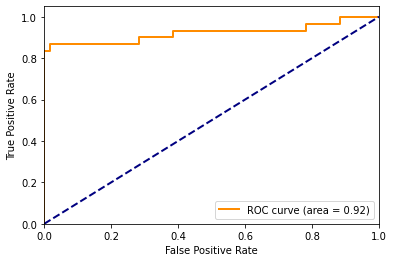

trainBold (180, 6428)
trainLabel (180, 1)
testBold (90, 6428)
testLabel (90, 1)
Accuracy = 0.18888888888888888


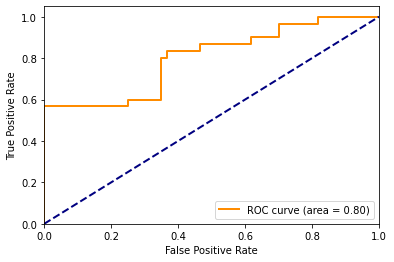

006
trainBold (180, 7477)
trainLabel (180, 1)
testBold (90, 7477)
testLabel (90, 1)
Accuracy = 0.3


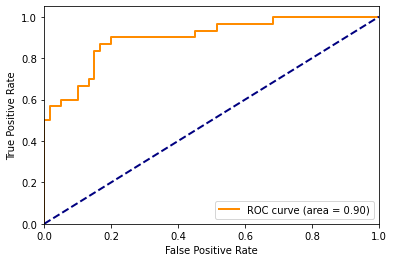

trainBold (180, 7477)
trainLabel (180, 1)
testBold (90, 7477)
testLabel (90, 1)
Accuracy = 0.28888888888888886


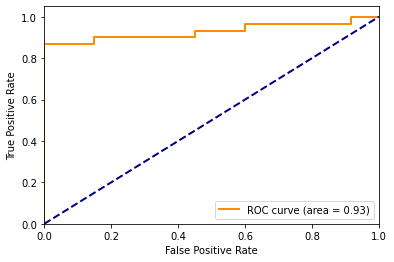

trainBold (180, 7477)
trainLabel (180, 1)
testBold (90, 7477)
testLabel (90, 1)
Accuracy = 0.2777777777777778


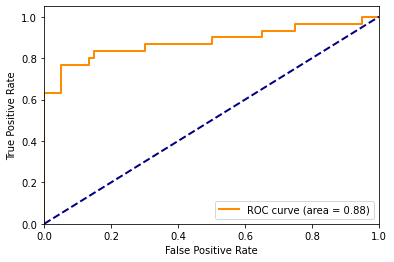

007
trainBold (180, 7187)
trainLabel (180, 1)
testBold (90, 7187)
testLabel (90, 1)
Accuracy = 0.26666666666666666


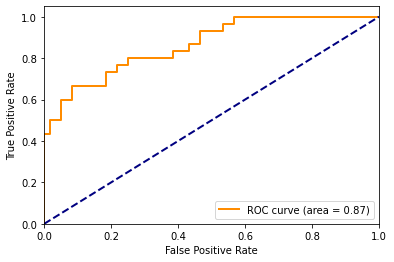

trainBold (180, 7187)
trainLabel (180, 1)
testBold (90, 7187)
testLabel (90, 1)
Accuracy = 0.2111111111111111


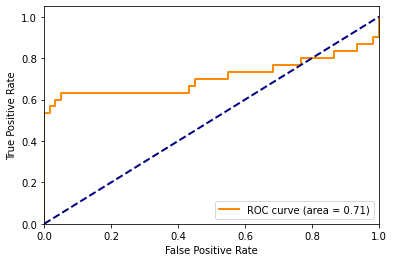

trainBold (180, 7187)
trainLabel (180, 1)
testBold (90, 7187)
testLabel (90, 1)
Accuracy = 0.2777777777777778


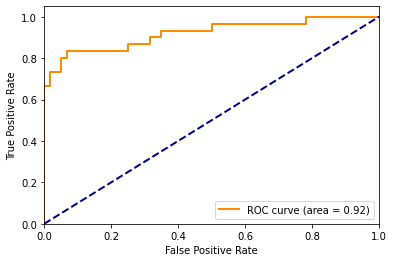

mean roc auc 0.8738271604938272


In [21]:
for eachSubj in range(len(sub_list)):
    subNum = sub_list[eachSubj]
    print(subNum)
    
    localizerBold = getBold(subNum,'localizer','bilateral_oc-temp')
    localizerLabel = getLabel(subNum,'localizer')
    #print(trainLabel[:5])
    #print(trainLabel[-5:])
    
    fold1_bold_train,fold2_bold_train,fold3_bold_train,fold1_labels_train,fold2_labels_train,fold3_labels_train,fold1_bold_test,fold2_bold_test,fold3_bold_test,fold1_labels_test,fold2_labels_test,fold3_labels_test = split(localizerBold,localizerLabel,90)
    
    for eachFold in range(3):
        
        trainBold,trainLabel,testBold,testLabel = get_bold_and_labels(eachFold+1,fold1_bold_train,fold2_bold_train,fold3_bold_train,fold1_labels_train,fold2_labels_train,fold3_labels_train,fold1_bold_test,fold2_bold_test,fold3_bold_test,fold1_labels_test,fold2_labels_test,fold3_labels_test)
        trainLabel = binarize(trainLabel,'faces')
        print('trainBold',trainBold.shape)
        print('trainLabel',trainLabel.shape)
        print('testBold',testBold.shape)
        print('testLabel',testLabel.shape)
        
        score, prediction, prediction_prob = classifier(trainBold,trainLabel,testBold,testLabel,model_linReg_1,1)
        #print(prediction_prob[:5,:])

        y_true = np.ravel(testLabel)
        y_true = list(y_true)
        #print(y_true)

        y_score = prediction_prob[:,1]
        #print(y_score)

        roc_auc = calc_auc(y_true,y_score)

        if eachSubj == 0 and eachFold == 0:
            roc_auc_sum = roc_auc
        else:
            roc_auc_sum = roc_auc_sum + roc_auc

mean_roc_auc = roc_auc_sum/(3*len(sub_list))
print('mean roc auc', mean_roc_auc)

In [26]:
#load file for each subject and concatenate
labels = []
bold_data = []

for eachParti in range (len(sub_list)):
    this_sub = sub_list[eachParti]
    
    for eachTask in range(len(task_list)):
        this_task = task_list[eachTask]
        
        label_dir = data_dir + '/label_list_%s/labels_%s.csv' % (this_task, this_sub)
        thisLabel = open(label_dir)
        thisLabel = csv.reader(thisLabel)
        thisLabel = list(thisLabel)
        thisLabel = np.array(thisLabel)
        thisLabel = np.float64(thisLabel)
        
        labels.append(thisLabel)
        
        for eachMask in range(len(mask_list)):
            this_mask = mask_list[eachMask]
            
            bold_dir = data_dir + '/bold_data_%s/%s/bold_%s.csv' % (this_task, this_mask, this_sub)
            thisBold = open(label_dir)
            thisBold = csv.reader(thisBold)
            thisBold = list(thisBold)
            thisBold = np.array(thisBold)
            thisBold = np.float64(thisBold)

            #bold_data[eachParti][eachTask][eachMask] = thisBold

print(labels)
print('labels has shape', labels.shape)
print('')
print('bold_data has shape', bold_data.shape)

[array([[3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.]

AttributeError: 'list' object has no attribute 'shape'